### Question 1: Transformer model

As a Machine Learning engineer at a tech company, you were given a task to develop a machine translation system that translates **English (source) to German (Target)**. You can use existing libraries but the training needs to be done from scratch (usage of pretrained weights is not allowed). You have the freedom to select any dataset for training the model. Use a small subset of data as a validation dataset and report the BLEU score on the validation set. Also, provide a short description of your transformer model architecture, hyperparameters, and training (also provide the training loss curve).

**Dataset**

Here are some of the parallel datasets (see Datasets and Resources file):
* Europarl Parallel corpus - https://www.statmt.org/europarl/v7/de-en.tgz
* News Commentary - https://www.statmt.org/wmt14/training-parallel-nc-v9.tgz (use DE-EN parallel data)
* Common Crawl corpus - https://www.statmt.org/wmt13/training-parallel-commoncrawl.tgz (use DE-EN parallel data)

You can also use other datasets of your choice. In the above datasets, **'.en'** file has the text in English, and **'.de'** file contains their corresponding German translations.

## Notes:

1) You can also consider using a small subset of the dataset if the training dataset is large
2) Sometimes you can also get out of memory errors while training, so choose the hyperparameters carefully.
3) Your training will be much faster if you use a GPU. If you are using a CPU, it may take several hours or even days. (you can also use Google Colab GPUs for training. link: https://colab.research.google.com/)

In [1]:
import torch

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

mps


In [2]:
#check the data
import pandas as pd

path_de = 'train_dataset/Europarl/europarl-v7.de-en.de'
data_de = open(path_de)
data_de = data_de.readlines()
print(len(data_de))
print(type(data_de))


path_en = 'train_dataset/Europarl/europarl-v7.de-en.en'
data_en = open(path_en)
data_en = data_en.readlines()
print(len(data_en))
print(type(data_en))

print(data_en[-3])
print(data_de[-3])

#looks good

1920209
<class 'list'>
1920209
<class 'list'>
Adjournment of the session

Unterbrechung der Sitzungsperiode



In [3]:
import torch
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Set device
device = torch.device('mps' if torch.has_mps else 'cpu')
print(device)

# Load T5 tokenizer
model_name = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Initialize T5 model from scratch
config = T5Config.from_pretrained(model_name)
model = T5ForConditionalGeneration(config).to(device)

# Function to initialize weights
def initialize_weights(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, torch.nn.Embedding):
        torch.nn.init.xavier_uniform_(module.weight)
    elif isinstance(module, torch.nn.LayerNorm):
        torch.nn.init.ones_(module.weight)
        torch.nn.init.zeros_(module.bias)

# Apply the weights initialization
model.apply(initialize_weights)

# Read data
path_de = 'train_dataset/Europarl/europarl-v7.de-en.de'
path_en = 'train_dataset/Europarl/europarl-v7.de-en.en'

with open(path_de, 'r', encoding='utf-8') as f:
    data_de = f.readlines()

with open(path_en, 'r', encoding='utf-8') as f:
    data_en = f.readlines()

# Prepare data
class TranslationDataset(Dataset):
    def __init__(self, src_texts, tgt_texts, tokenizer, max_len=128):
        self.src_texts = src_texts
        self.tgt_texts = tgt_texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.src_texts)

    def __getitem__(self, idx):
        src_text = self.src_texts[idx]
        tgt_text = self.tgt_texts[idx]

        src_encoding = self.tokenizer(
            src_text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
        )
        tgt_encoding = self.tokenizer(
            tgt_text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
        )

        labels = tgt_encoding.input_ids
        labels[labels == self.tokenizer.pad_token_id] = -100  # Ignore padding tokens in the loss

        return {
            'input_ids': src_encoding.input_ids.flatten(),
            'attention_mask': src_encoding.attention_mask.flatten(),
            'labels': labels.flatten()
        }

torch.backends.mps.is_built()

# Split data into train and validation sets
src_train, src_val, tgt_train, tgt_val = train_test_split(data_en, data_de, test_size=0.1, random_state=42)

train_dataset = TranslationDataset(src_train, tgt_train, tokenizer)
val_dataset = TranslationDataset(src_val, tgt_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

/var/folders/n2/v7krv3hd7f9_j02wpl4_74000000gn/T/ipykernel_16318/2103288745.py:12: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device('mps' if torch.has_mps else 'cpu')
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


mps


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# Training function
def train_model(model, train_loader, val_loader, epochs, learning_rate, checkpoint_dir):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    model.train()
    loss_values = []

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}') as pbar:
            for batch in train_loader:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                pbar.update(1)

        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}')

        # Save checkpoint
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        checkpoint_path = os.path.join(checkpoint_dir, f't5_model_epoch_{epoch+1}_loss_{avg_loss:.4f}.pt')
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Checkpoint saved at {checkpoint_path}')

    return loss_values



# Evaluation function
def evaluate_bleu(model, tokenizer, val_loader):
    model.eval()
    translations = []
    references = []

    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=50, num_beams=4, early_stopping=True)
            decoded_outputs = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
            decoded_labels = [tokenizer.decode(label[label != -100], skip_special_tokens=True) for label in labels]

        translations.extend(decoded_outputs)
        references.extend(decoded_labels)

    bleu_scores = []
    smoothie = SmoothingFunction().method4
    for ref, trans in zip(references, translations):
        bleu_score = sentence_bleu([ref.split()], trans.split(), smoothing_function=smoothie)
        bleu_scores.append(bleu_score)

    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu_score




Epoch 1/10: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]


Epoch 1/10, Loss: 8.043860703706741
Checkpoint saved at checkpoints/t5_model_epoch_1_loss_8.0439.pt


Epoch 2/10: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


Epoch 2/10, Loss: 6.4487302005290985
Checkpoint saved at checkpoints/t5_model_epoch_2_loss_6.4487.pt


Epoch 3/10: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


Epoch 3/10, Loss: 6.386889681220055
Checkpoint saved at checkpoints/t5_model_epoch_3_loss_6.3869.pt


Epoch 4/10: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


Epoch 4/10, Loss: 6.348598003387451
Checkpoint saved at checkpoints/t5_model_epoch_4_loss_6.3486.pt


Epoch 5/10: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


Epoch 5/10, Loss: 6.309913158416748
Checkpoint saved at checkpoints/t5_model_epoch_5_loss_6.3099.pt


Epoch 6/10: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]


Epoch 6/10, Loss: 6.274297431111336
Checkpoint saved at checkpoints/t5_model_epoch_6_loss_6.2743.pt


Epoch 7/10: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


Epoch 7/10, Loss: 6.278198689222336
Checkpoint saved at checkpoints/t5_model_epoch_7_loss_6.2782.pt


Epoch 8/10: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


Epoch 8/10, Loss: 6.235140904784203
Checkpoint saved at checkpoints/t5_model_epoch_8_loss_6.2351.pt


Epoch 9/10: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Epoch 9/10, Loss: 6.213334500789642
Checkpoint saved at checkpoints/t5_model_epoch_9_loss_6.2133.pt


Epoch 10/10: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Epoch 10/10, Loss: 6.197231963276863
Checkpoint saved at checkpoints/t5_model_epoch_10_loss_6.1972.pt


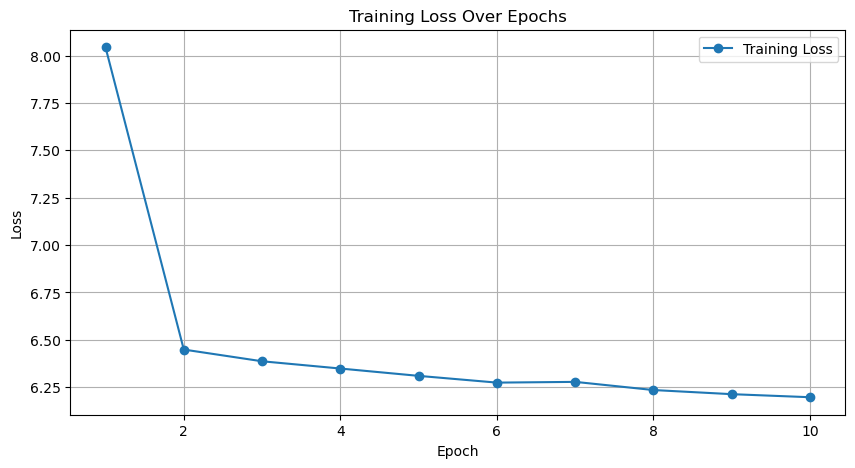

In [15]:
# Train the model with mini subset
#create a small dataset to test
src_train_small = src_train[:1000]
tgt_train_small = tgt_train[:1000]
src_val_small = src_val[:100]
tgt_val_small = tgt_val[:100]

train_dataset_small = TranslationDataset(src_train_small, tgt_train_small, tokenizer)
val_dataset_small = TranslationDataset(src_val_small, tgt_val_small, tokenizer)

train_loader_small = DataLoader(train_dataset_small, batch_size=32, shuffle=True)
val_loader_small = DataLoader(val_dataset_small, batch_size=32)

# Train the model
epochs = 10
learning_rate = 0.005
checkpoint_dir = 'checkpoints'
loss_values = train_model(model, train_loader_small, val_loader_small, epochs, learning_rate, checkpoint_dir)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
#lets make hyperparameter tuning
# Hyperparameter tuning
learning_rates = [0.001, 0.005, 0.01]
epochs = [3,5]
best_bleu_score = 0
best_hyperparameters = {}

for lr in learning_rates:
    for epoch in epochs:
        model = T5ForConditionalGeneration(config).to(device)
        model.apply(initialize_weights)
        loss_values = train_model(model, train_loader_small, val_loader_small, epoch, lr, checkpoint_dir)
        bleu_score = evaluate_bleu(model, tokenizer, val_loader_small)
        print(f'Learning Rate: {lr}, Epochs: {epoch}, BLEU Score: {bleu_score}')

        if bleu_score > best_bleu_score:
            best_bleu_score = bleu_score
            best_hyperparameters['learning_rate'] = lr
            best_hyperparameters['epochs'] = epoch
            best_hyperparameters['model'] = model

print(f'Best BLEU Score: {best_bleu_score}')
print(f'Best Hyperparameters: {best_hyperparameters}')


Epoch 1/3: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Epoch 1/3, Loss: 10.096110582351685
Checkpoint saved at checkpoints/t5_model_epoch_1_loss_10.0961.pt


Epoch 2/3: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Epoch 2/3, Loss: 9.405233651399612
Checkpoint saved at checkpoints/t5_model_epoch_2_loss_9.4052.pt


Epoch 3/3: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Epoch 3/3, Loss: 8.791210412979126
Checkpoint saved at checkpoints/t5_model_epoch_3_loss_8.7912.pt
Learning Rate: 0.001, Epochs: 3, BLEU Score: 0.0


Epoch 1/5: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s]


Epoch 1/5, Loss: 10.09325161576271
Checkpoint saved at checkpoints/t5_model_epoch_1_loss_10.0933.pt


Epoch 2/5: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Epoch 2/5, Loss: 9.395089209079742
Checkpoint saved at checkpoints/t5_model_epoch_2_loss_9.3951.pt


Epoch 3/5: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s]


Epoch 3/5, Loss: 8.773031860589981
Checkpoint saved at checkpoints/t5_model_epoch_3_loss_8.7730.pt


Epoch 4/5: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Epoch 4/5, Loss: 8.28006798028946
Checkpoint saved at checkpoints/t5_model_epoch_4_loss_8.2801.pt


Epoch 5/5: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


Epoch 5/5, Loss: 7.885909676551819
Checkpoint saved at checkpoints/t5_model_epoch_5_loss_7.8859.pt
Learning Rate: 0.001, Epochs: 5, BLEU Score: 0.0031944005473655544


Epoch 1/3: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]


Epoch 1/3, Loss: 9.170050024986267
Checkpoint saved at checkpoints/t5_model_epoch_1_loss_9.1701.pt


Epoch 2/3: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


Epoch 2/3, Loss: 7.4246000200510025
Checkpoint saved at checkpoints/t5_model_epoch_2_loss_7.4246.pt


Epoch 3/3: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]


Epoch 3/3, Loss: 6.877602741122246
Checkpoint saved at checkpoints/t5_model_epoch_3_loss_6.8776.pt
Learning Rate: 0.005, Epochs: 3, BLEU Score: 0.0


Epoch 1/5: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


Epoch 1/5, Loss: 9.133378565311432
Checkpoint saved at checkpoints/t5_model_epoch_1_loss_9.1334.pt


Epoch 2/5: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


Epoch 2/5, Loss: 7.381121829152107
Checkpoint saved at checkpoints/t5_model_epoch_2_loss_7.3811.pt


Epoch 3/5: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


Epoch 3/5, Loss: 6.831677943468094
Checkpoint saved at checkpoints/t5_model_epoch_3_loss_6.8317.pt


Epoch 4/5: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]


Epoch 4/5, Loss: 6.5285631865262985
Checkpoint saved at checkpoints/t5_model_epoch_4_loss_6.5286.pt


Epoch 5/5: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


Epoch 5/5, Loss: 6.395679742097855
Checkpoint saved at checkpoints/t5_model_epoch_5_loss_6.3957.pt
Learning Rate: 0.005, Epochs: 5, BLEU Score: 0.0


Epoch 1/3: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


Epoch 1/3, Loss: 8.481101676821709
Checkpoint saved at checkpoints/t5_model_epoch_1_loss_8.4811.pt


Epoch 2/3: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]


Epoch 2/3, Loss: 6.819018855690956
Checkpoint saved at checkpoints/t5_model_epoch_2_loss_6.8190.pt


Epoch 3/3: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Epoch 3/3, Loss: 6.488662302494049
Checkpoint saved at checkpoints/t5_model_epoch_3_loss_6.4887.pt
Learning Rate: 0.01, Epochs: 3, BLEU Score: 0.0


Epoch 1/5: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]


Epoch 1/5, Loss: 8.493177071213722
Checkpoint saved at checkpoints/t5_model_epoch_1_loss_8.4932.pt


Epoch 2/5: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Epoch 2/5, Loss: 6.830752789974213
Checkpoint saved at checkpoints/t5_model_epoch_2_loss_6.8308.pt


Epoch 3/5: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]


Epoch 3/5, Loss: 6.49367681145668
Checkpoint saved at checkpoints/t5_model_epoch_3_loss_6.4937.pt


Epoch 4/5: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]


Epoch 4/5, Loss: 6.435789257287979
Checkpoint saved at checkpoints/t5_model_epoch_4_loss_6.4358.pt


Epoch 5/5: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]


Epoch 5/5, Loss: 6.333873778581619
Checkpoint saved at checkpoints/t5_model_epoch_5_loss_6.3339.pt
Learning Rate: 0.01, Epochs: 5, BLEU Score: 0.0
Best BLEU Score: 0.0031944005473655544
Best Hyperparameters: {'learning_rate': 0.001, 'epochs': 5, 'model': T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
         

In [34]:
# Training parameters
epochs = 5
learning_rate = 0.003
checkpoint_dir = 'checkpoints_t5'
batch_size = 32

# Manual split
num_parts = 6
chunk_size = len(data_de) // num_parts

# Part 1
start_idx_1, end_idx_1 = 0, chunk_size
src_train_part_1 = data_en[start_idx_1:end_idx_1]
tgt_train_part_1 = data_de[start_idx_1:end_idx_1]

# Part 2
start_idx_2, end_idx_2 = chunk_size, 2 * chunk_size
src_train_part_2 = data_en[start_idx_2:end_idx_2]
tgt_train_part_2 = data_de[start_idx_2:end_idx_2]

# Part 3
start_idx_3, end_idx_3 = 2 * chunk_size, 3 * chunk_size
src_train_part_3 = data_en[start_idx_3:end_idx_3]
tgt_train_part_3 = data_de[start_idx_3:end_idx_3]

# Part 4
start_idx_4, end_idx_4 = 3 * chunk_size, 4 * chunk_size
src_train_part_4 = data_en[start_idx_4:end_idx_4]
tgt_train_part_4 = data_de[start_idx_4:end_idx_4]

# Part 5
start_idx_5, end_idx_5 = 4 * chunk_size, 5 * chunk_size
src_train_part_5 = data_en[start_idx_5:end_idx_5]
tgt_train_part_5 = data_de[start_idx_5:end_idx_5]

# Part 6 (remaining data)
start_idx_6, end_idx_6 = 5 * chunk_size, len(data_de)
src_train_part_6 = data_en[start_idx_6:end_idx_6]
tgt_train_part_6 = data_de[start_idx_6:end_idx_6]

# Create data loaders for each part
train_dataset_1 = TranslationDataset(src_train_part_1, tgt_train_part_1, tokenizer)
train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)

train_dataset_2 = TranslationDataset(src_train_part_2, tgt_train_part_2, tokenizer)
train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)

train_dataset_3 = TranslationDataset(src_train_part_3, tgt_train_part_3, tokenizer)
train_loader_3 = DataLoader(train_dataset_3, batch_size=batch_size, shuffle=True)

train_dataset_4 = TranslationDataset(src_train_part_4, tgt_train_part_4, tokenizer)
train_loader_4 = DataLoader(train_dataset_4, batch_size=batch_size, shuffle=True)

train_dataset_5 = TranslationDataset(src_train_part_5, tgt_train_part_5, tokenizer)
train_loader_5 = DataLoader(train_dataset_5, batch_size=batch_size, shuffle=True)

train_dataset_6 = TranslationDataset(src_train_part_6, tgt_train_part_6, tokenizer)
train_loader_6 = DataLoader(train_dataset_6, batch_size=batch_size, shuffle=True)

# Function to save checkpoint
def save_checkpoint(model, optimizer, epoch, checkpoint_dir, part):
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_part_{part}_epoch_{epoch}.pt')
    os.makedirs(checkpoint_dir, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print(f'Checkpoint saved at {checkpoint_path}')

# Function to load checkpoint
def load_checkpoint(model, optimizer, checkpoint_dir, part):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith(f'checkpoint_part_{part}_')]
    if not checkpoint_files:
        return 0  # No checkpoints found, start from epoch 0
    latest_checkpoint = sorted(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))[-1]
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f'Checkpoint loaded from {checkpoint_path}, resuming training from epoch {start_epoch}')
    return start_epoch


In [35]:
# Training function
def train_model(model, dataloader, epochs, learning_rate, checkpoint_dir, part):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    start_epoch = load_checkpoint(model, optimizer, checkpoint_dir, part)
    loss_values = []

    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        with tqdm(total=len(dataloader), desc=f'Epoch {epoch+1}/{epochs} (Part {part})') as pbar:
            for batch in dataloader:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                pbar.set_postfix({'loss': total_loss / (pbar.n + 1)})
                pbar.update(1)

        avg_loss = total_loss / len(dataloader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}')
        save_checkpoint(model, optimizer, epoch, checkpoint_dir, part)

    return loss_values


Epoch 1/5 (Part 1): 100%|██████████| 10002/10002 [1:10:50<00:00,  2.35it/s, loss=5.95]


Epoch 1/5, Loss: 5.949157538544629
Checkpoint saved at checkpoints_t5/checkpoint_part_1_epoch_0.pt


Epoch 2/5 (Part 1): 100%|██████████| 10002/10002 [1:10:48<00:00,  2.35it/s, loss=5.71]


Epoch 2/5, Loss: 5.706046267524526
Checkpoint saved at checkpoints_t5/checkpoint_part_1_epoch_1.pt


Epoch 3/5 (Part 1): 100%|██████████| 10002/10002 [1:11:08<00:00,  2.34it/s, loss=5.56]


Epoch 3/5, Loss: 5.555838223911004
Checkpoint saved at checkpoints_t5/checkpoint_part_1_epoch_2.pt


Epoch 4/5 (Part 1): 100%|██████████| 10002/10002 [1:11:24<00:00,  2.33it/s, loss=5.46]


Epoch 4/5, Loss: 5.463186717133502
Checkpoint saved at checkpoints_t5/checkpoint_part_1_epoch_3.pt


Epoch 5/5 (Part 1): 100%|██████████| 10002/10002 [1:12:07<00:00,  2.31it/s, loss=5.49]


Epoch 5/5, Loss: 5.491880672832795
Checkpoint saved at checkpoints_t5/checkpoint_part_1_epoch_4.pt


Epoch 1/5 (Part 2): 100%|██████████| 10002/10002 [1:15:20<00:00,  2.21it/s, loss=5.34]


Epoch 1/5, Loss: 5.339317402966474
Checkpoint saved at checkpoints_t5/checkpoint_part_2_epoch_0.pt


Epoch 2/5 (Part 2): 100%|██████████| 10002/10002 [1:17:25<00:00,  2.15it/s, loss=5.28]


Epoch 2/5, Loss: 5.280064149180356
Checkpoint saved at checkpoints_t5/checkpoint_part_2_epoch_1.pt


Epoch 3/5 (Part 2): 100%|██████████| 10002/10002 [1:17:56<00:00,  2.14it/s, loss=5.3] 


Epoch 3/5, Loss: 5.304976251167766
Checkpoint saved at checkpoints_t5/checkpoint_part_2_epoch_2.pt


Epoch 4/5 (Part 2): 100%|██████████| 10002/10002 [1:43:52<00:00,  1.60it/s, loss=5.26]  


Epoch 4/5, Loss: 5.257578409664442
Checkpoint saved at checkpoints_t5/checkpoint_part_2_epoch_3.pt


Epoch 5/5 (Part 2): 100%|██████████| 10002/10002 [1:33:31<00:00,  1.78it/s, loss=5.28]  


Epoch 5/5, Loss: 5.281784280398635
Checkpoint saved at checkpoints_t5/checkpoint_part_2_epoch_4.pt
Final model saved at checkpoints_t5/t5_final_model.pt


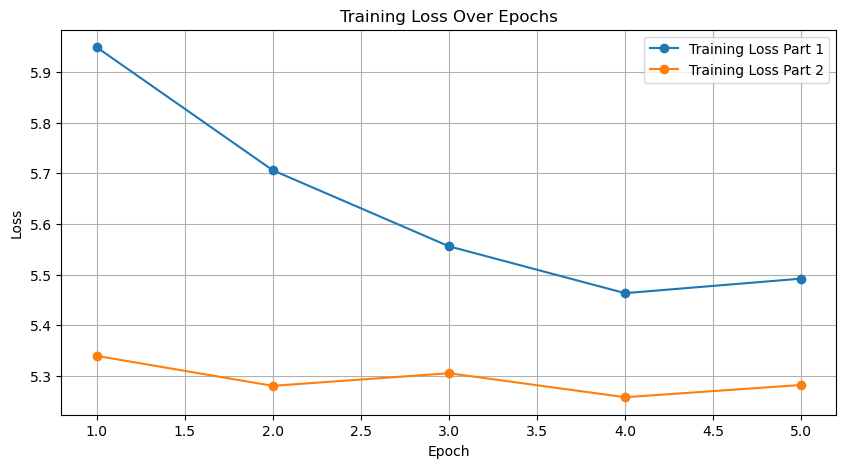

In [39]:
# Train the model on each part
loss_values_1 = train_model(model, train_loader_1, epochs, learning_rate, checkpoint_dir, 1)
loss_values_2 = train_model(model, train_loader_2, epochs, learning_rate, checkpoint_dir, 2)
# loss_values_3 = train_model(model, train_loader_3, epochs, learning_rate, checkpoint_dir, 3)
# loss_values_4 = train_model(model, train_loader_4, epochs, learning_rate, checkpoint_dir, 4)
# loss_values_5 = train_model(model, train_loader_5, epochs, learning_rate, checkpoint_dir, 5)
# loss_values_6 = train_model(model, train_loader_6, epochs, learning_rate, checkpoint_dir, 6)

# Save the final model
final_model_path = os.path.join(checkpoint_dir, 't5_final_model.pt')
torch.save(model.state_dict(), final_model_path)
print(f'Final model saved at {final_model_path}')

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_values_1, marker='o', label='Training Loss Part 1')
plt.plot(range(1, epochs + 1), loss_values_2, marker='o', label='Training Loss Part 2')
# plt.plot(range(1, epochs + 1), loss_values_3, marker='o', label='Training Loss Part 3')
# plt.plot(range(1, epochs + 1), loss_values_4, marker='o', label='Training Loss Part 4')
# plt.plot(range(1, epochs + 1), loss_values_5, marker='o', label='Training Loss Part 5')
# plt.plot(range(1, epochs + 1), loss_values_6, marker='o', label='Training Loss Part 6')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Split data for validation
# src_train, src_val, tgt_train, tgt_val = train_test_split(data_en, data_de, test_size=0.01, random_state=42)
val_dataset_small = TranslationDataset(src_val[:1000], tgt_val[:1000], tokenizer)
val_loader_small = DataLoader(val_dataset_small, batch_size=batch_size)

# Evaluate the model
bleu_score = evaluate_bleu(model, tokenizer, val_loader_small)
print(f'Validation BLEU Score: {bleu_score}')

Validation BLEU Score: 0.005039067416721451


Model Architecture:
Transformer Model: T5 (t5-small), initialized from scratch.
Layers: The T5 model has a series of encoder and decoder layers with self-attention mechanisms.
Tokenizer: T5 tokenizer for tokenizing input and output sentences.
Hyperparameters:

Epochs: 5
Learning Rate: 0.003
Batch Size: 32
Gradient Accumulation Steps: 4 (to effectively increase batch size without running out of memory)

Training Process:

Initialization: Model weights are initialized using Xavier uniform initialization.

Training: Model is trained over multiple epochs with AdamW optimizer. Checkpoints are saved after each epoch.

Loss Calculation: Cross-entropy loss is used, ignoring the padding tokens in the target sequence.

Evaluation: BLEU score is calculated on a separate validation set after training.


In [45]:
def translate_text(model, tokenizer, text, max_length=50):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    print(f"Input IDs: {input_ids}")
    print(f"Attention Mask: {attention_mask}")

    # Generate translation
    model.eval()
    with torch.no_grad():
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=4, early_stopping=True)

    print(f"Generated Tokens: {outputs}")

    # Decode the generated tokens to get the translation
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Example usage
example_text = "Please rise, then, for this minute' s silence."
translated_text = translate_text(model, tokenizer, example_text)
print(f"Original: {example_text}")
print(f"Translation: {translated_text}")



Input IDs: tensor([[  863,  3098,     6,   258,     6,    21,    48,  1962,    31,     3,
             7, 10844,     5,     1,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='mps:0')
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], device='mps:0')
Generated Tokens: tensor([[   0,  316,  229,    3,   15,    7,    6,  602,   67, 5837, 5451,   35,
            5,    1]], device='mps:0')
Original: Please rise, then, for this minute' s silence.
Translation: Die ist es, dass die Kommissionen.


In [65]:
# Load the model weights from the checkpoint
checkpoint_dir = 'checkpoints_t5'
checkpoint_path = os.path.join(checkpoint_dir, 't5_final_model.pt')
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)
print(f"Loaded model from {checkpoint_path}")

# Read the new data
new_path_de = 'new_dataset/new_de-en.de'
new_path_en = 'new_dataset/new_de-en.en'

with open(new_path_de, 'r', encoding='utf-8') as f:
    new_data_de = f.readlines()

with open(new_path_en, 'r', encoding='utf-8') as f:
    new_data_en = f.readlines()


print(len(new_data_de))
print(len(new_data_en))

# clean the data
# Remove empty lines
new_data_de = [line.strip() for line in new_data_de if line.strip()]
new_data_en = [line.strip() for line in new_data_en if line.strip()]

# Remove long sentences
max_length = 128
new_data_de = [line for line in new_data_de if len(line.split()) <= max_length]
new_data_en = [line for line in new_data_en if len(line.split()) <= max_length]

print(len(new_data_de))
print(len(new_data_en))

# Prepare data
class TranslationDataset(Dataset):
    def __init__(self, src_texts, tgt_texts, tokenizer, max_len=128):
        self.src_texts = src_texts
        self.tgt_texts = tgt_texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.src_texts)

    def __getitem__(self, idx):
        src_text = self.src_texts[idx]
        tgt_text = self.tgt_texts[idx]

        src_encoding = self.tokenizer(
            src_text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
        )
        tgt_encoding = self.tokenizer(
            tgt_text, max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
        )

        labels = tgt_encoding.input_ids
        labels[labels == self.tokenizer.pad_token_id] = -100  # Ignore padding tokens in the loss

        return {
            'input_ids': src_encoding.input_ids.flatten(),
            'attention_mask': src_encoding.attention_mask.flatten(),
            'labels': labels.flatten()
        }



Loaded model from checkpoints_t5/t5_final_model.pt
1165
1000
1000
1000


Loaded model from checkpoints_t5/t5_final_model.pt


Epoch 1/20 (Part new): 100%|██████████| 32/32 [00:25<00:00,  1.26it/s, loss=5.66]


Epoch 1/20, Loss: 5.6558284014463425
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_0.pt


Epoch 2/20 (Part new): 100%|██████████| 32/32 [00:13<00:00,  2.30it/s, loss=4.81]


Epoch 2/20, Loss: 4.8148903995752335
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_1.pt


Epoch 3/20 (Part new): 100%|██████████| 32/32 [00:13<00:00,  2.41it/s, loss=4.58]


Epoch 3/20, Loss: 4.58166316151619
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_2.pt


Epoch 4/20 (Part new): 100%|██████████| 32/32 [00:12<00:00,  2.51it/s, loss=4.46]


Epoch 4/20, Loss: 4.4647631496191025
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_3.pt


Epoch 5/20 (Part new): 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, loss=4.34]


Epoch 5/20, Loss: 4.341987386345863
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_4.pt


Epoch 6/20 (Part new): 100%|██████████| 32/32 [00:12<00:00,  2.49it/s, loss=4.26]


Epoch 6/20, Loss: 4.26268544793129
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_5.pt


Epoch 7/20 (Part new): 100%|██████████| 32/32 [00:13<00:00,  2.40it/s, loss=4.2] 


Epoch 7/20, Loss: 4.199431121349335
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_6.pt


Epoch 8/20 (Part new): 100%|██████████| 32/32 [00:12<00:00,  2.54it/s, loss=4.12]


Epoch 8/20, Loss: 4.123682662844658
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_7.pt


Epoch 9/20 (Part new): 100%|██████████| 32/32 [00:12<00:00,  2.54it/s, loss=4.07]


Epoch 9/20, Loss: 4.073017001152039
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_8.pt


Epoch 10/20 (Part new): 100%|██████████| 32/32 [00:12<00:00,  2.53it/s, loss=4.02]


Epoch 10/20, Loss: 4.024856135249138
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_9.pt


Epoch 11/20 (Part new): 100%|██████████| 32/32 [00:13<00:00,  2.35it/s, loss=3.97]


Epoch 11/20, Loss: 3.9730312451720238
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_10.pt


Epoch 12/20 (Part new): 100%|██████████| 32/32 [00:14<00:00,  2.26it/s, loss=3.96]


Epoch 12/20, Loss: 3.964970886707306
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_11.pt


Epoch 13/20 (Part new): 100%|██████████| 32/32 [00:15<00:00,  2.04it/s, loss=3.9] 


Epoch 13/20, Loss: 3.896428018808365
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_12.pt


Epoch 14/20 (Part new): 100%|██████████| 32/32 [00:16<00:00,  1.95it/s, loss=3.86]


Epoch 14/20, Loss: 3.8592383414506912
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_13.pt


Epoch 15/20 (Part new): 100%|██████████| 32/32 [00:17<00:00,  1.86it/s, loss=3.83]


Epoch 15/20, Loss: 3.8265662491321564
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_14.pt


Epoch 16/20 (Part new): 100%|██████████| 32/32 [00:18<00:00,  1.72it/s, loss=3.83]


Epoch 16/20, Loss: 3.82973051071167
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_15.pt


Epoch 17/20 (Part new): 100%|██████████| 32/32 [00:18<00:00,  1.76it/s, loss=3.88]


Epoch 17/20, Loss: 3.880869559943676
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_16.pt


Epoch 18/20 (Part new): 100%|██████████| 32/32 [00:18<00:00,  1.77it/s, loss=3.85]


Epoch 18/20, Loss: 3.8456354290246964
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_17.pt


Epoch 19/20 (Part new): 100%|██████████| 32/32 [00:17<00:00,  1.86it/s, loss=3.9] 


Epoch 19/20, Loss: 3.9005901366472244
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_18.pt


Epoch 20/20 (Part new): 100%|██████████| 32/32 [00:16<00:00,  1.99it/s, loss=3.93]


Epoch 20/20, Loss: 3.929352767765522
Checkpoint saved at checkpoints_t5/checkpoint_part_new_epoch_19.pt
Final model saved at checkpoints_t5/t5_final_model_further_trained.pt


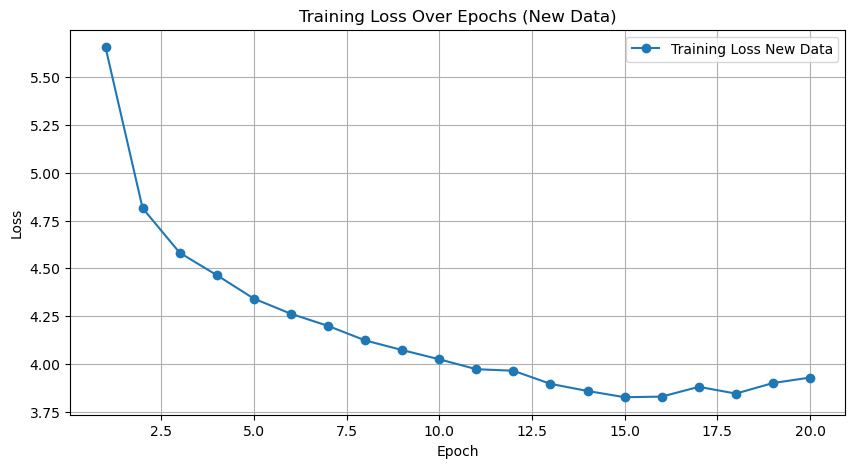

In [66]:

# Create data loader for the new dataset :/ :) 
batch_size = 32
new_train_dataset = TranslationDataset(new_data_en, new_data_de, tokenizer)
new_train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)

# Training parameters
epochs = 20
learning_rate = 0.003

# Load the model weights from the checkpoint
checkpoint_dir = 'checkpoints_t5'
checkpoint_path = os.path.join(checkpoint_dir, 't5_final_model.pt')
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)
print(f"Loaded model from {checkpoint_path}")


# Train the model on the new dataset
loss_values_new = train_model(model, new_train_loader, epochs, learning_rate, checkpoint_dir, 'new')

# Save the final model after further training
final_model_path_new = os.path.join(checkpoint_dir, 't5_final_model_further_trained.pt')
torch.save(model.state_dict(), final_model_path_new)
print(f'Final model saved at {final_model_path_new}')

# Plot training loss
plt.figure(figsize=(10, 5))
# Adjust the x-axis range to match the length of loss_values_new
plt.plot(range(1, len(loss_values_new) + 1), loss_values_new, marker='o', label='Training Loss New Data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs (New Data)')
plt.legend()
plt.grid(True)
plt.show()



In [77]:
def translate_text(model, tokenizer, text, max_length=50):
    model.eval()  # Set the model to evaluation mode
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():  # No need to track the gradients
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=4,
            early_stopping=True
        )

    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Example usage
example_texts = [
    "This is a test sentence to translate from English to German.",
    "How are you doing today?",
    "The weather is nice and sunny.",
    "Can you help me with my homework?",
    "I would like to book a table for two at your restaurant."
]

for example_text in example_texts:
    translated_text = translate_text(model, tokenizer, example_text)
    print(f"Original: {example_text}")
    print(f"Translation: {translated_text}")


Original: This is a test sentence to translate from English to German.
Translation: Ein Mann in einem roten Hemd spielt.
Original: How are you doing today?
Translation: Ein Mann in einem roten Hemd spielt.
Original: The weather is nice and sunny.
Translation: Ein Mann in einem roten Hemd.
Original: Can you help me with my homework?
Translation: Ein Mann in einem roten Hemd.
Original: I would like to book a table for two at your restaurant.
Translation: Ein Mann in einem roten Hemd und ein Erwachsene.


In [71]:
# Translation function
def translate_text(model, tokenizer, text, max_length=50):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=4, early_stopping=True)

    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return translated_text

# Example usage
example_text = "This is a test sentence to translate from English to German."
translated_text = translate_text(model, tokenizer, example_text)
print(f"Original: {example_text}")
print(f"Translation: {translated_text}")

example_text = "How are you doing today?"
translated_text = translate_text(model, tokenizer, example_text)
print(f"Original: {example_text}")
print(f"Translation: {translated_text}")

Original: This is a test sentence to translate from English to German.
Translation: Ein Mann in einem roten Hemd spielt.
Original: How are you doing today?
Translation: Ein Mann in einem roten Hemd spielt.


In [69]:
# Function to translate test sentences
def translate_test_sentences(model, tokenizer, sentences, max_length=50):
    translated_sentences = []
    model.eval()
    with torch.no_grad():
        for sentence in sentences:
            translated_sentence = translate_text(model, tokenizer, sentence, max_length)
            translated_sentences.append(translated_sentence)
    return translated_sentences

# Load the test data
test_file_path = 'test.en'

with open(test_file_path, 'r', encoding='utf-8') as f:
    test_sentences = f.readlines()

output_translated = translate_test_sentences(model, tokenizer, test_sentences[:10])
print(output_translated[:10])


['Ein Mann in einem roten Hemden Hemd und ein Erwachsene.', 'Ein Mann in einem roten Hemd und ein Erwachsene.', 'Ein Mann in einem roten Hemd und ein Erwachsene.', 'Ein Mann in einem roten Hemd und ein Erwachsene.', 'Ein Mann in einem roten Hemd spielt.', 'Ein Mann in einem roten Hemd und ein Erwachsene.', 'Ein Mann in einem roten Hemd und ein Erwachsene.', 'Ein Mann in einem roten Hemden Hemd und ein Erwachsene.', 'Ein Mann in einem roten Hemd spielt.', 'Ein Mann in einem roten Hemd und ein Erwachsene.']


https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

pretty nice tutorial to learn.

In [54]:
# my model works pretty bad.

example_text = "A man in an orange hat starring at something."
translated_text = translate_text(model, tokenizer, example_text)
print(f"Original: {example_text}")
print(f"Translation: {translated_text}")


Original: A man in an orange hat starring at something.
Translation: . Herr Präsident! Präsident! Präsident! Präsident! Präsident! Präsident! Präsident! Präsident! Präsident! Präsident! Präsident! Präsident! Präsident! Präsident! Präsident!


In [58]:
# i want to find the problem with the model

import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import os

# Set device
device = torch.device('mps' if torch.has_mps else 'cpu')
print(f'Device: {device}')

# Load T5 tokenizer and model architecture (no weights loaded yet)
model_name = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

# Load the fine-tuned model weights
checkpoint_dir = 'checkpoints_t5'
final_model_path = os.path.join(checkpoint_dir, 't5_final_model.pt')
if os.path.exists(final_model_path):
    model.load_state_dict(torch.load(final_model_path, map_location=device))  # Loading your fine-tuned weights
    print(f'Loaded model weights from {final_model_path}')
else:
    print(f'No checkpoint found at {final_model_path}. Ensure the path is correct.')

# Function to translate test sentences
def translate_test_sentences(model, tokenizer, sentences, max_length=50):
    translated_sentences = []
    model.eval()
    with torch.no_grad():
        for i, sentence in enumerate(sentences):
            inputs = tokenizer(sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            print(f"Input IDs: {input_ids}")
            print(f"Attention Mask: {attention_mask}")

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=4, early_stopping=True)
            print(f"Generated Tokens: {outputs}")

            translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            translated_sentences.append(translated_text)
            
            # Print the first 5 translations
            if i < 5:
                print(f"Original: {sentence.strip()}")
                print(f"Translation: {translated_text}")

    return translated_sentences

# Load the test data
test_file_path = 'test.en'

with open(test_file_path, 'r', encoding='utf-8') as f:
    test_sentences = f.readlines()

# Translate the test sentences and print the first few translations
translated_test_sentences = translate_test_sentences(model, tokenizer, test_sentences[:10])


/var/folders/n2/v7krv3hd7f9_j02wpl4_74000000gn/T/ipykernel_16318/3310692086.py:8: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device('mps' if torch.has_mps else 'cpu')


Device: mps


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded model weights from checkpoints_t5/t5_final_model.pt
Input IDs: tensor([[   71,   388,    16,    46,  5470,     3,   547,     3, 22236,    44,
           424,     5,     1,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='mps:0')
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], device='mps:0')
Generated Tokens: tensor([[    0,     3,     5,  8816,     3, 20962,    55,     3, 20962,    55,
             3, 20962,    55,     3, 20962,    55,     3, 20962,    55,     3,
         20962,    55,     3, 20962,    55,     3, 20962,    55,     3, 20962,
            55,     3, 20962,    55,     3, 

In [61]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import os

# Set device
device = torch.device('mps' if torch.backends.mps.is_built() else 'cpu')
print(f'Device: {device}')

# Load T5 tokenizer and model architecture (no weights loaded yet)
model_name = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

# Load the fine-tuned model weights
checkpoint_dir = 'checkpoints_t5'
final_model_path = os.path.join(checkpoint_dir, 't5_final_model.pt')
if os.path.exists(final_model_path):
    model.load_state_dict(torch.load(final_model_path, map_location=device))  # Loading your fine-tuned weights
    print(f'Loaded model weights from {final_model_path}')
else:
    print(f'No checkpoint found at {final_model_path}. Ensure the path is correct.')

# Function to translate test sentences
def translate_test_sentences(model, tokenizer, sentences, max_length=50):
    translated_sentences = []
    model.eval()
    with torch.no_grad():
        for i, sentence in enumerate(sentences):
            inputs = tokenizer(sentence, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            print(f"Input IDs: {input_ids}")
            print(f"Attention Mask: {attention_mask}")

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=4, early_stopping=True)
            print(f"Generated Tokens: {outputs}")

            translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            translated_sentences.append(translated_text)
            
            # Print the first 10 translations
            if i < 10:
                print(f"Original: {sentence.strip()}")
                print(f"Translation: {translated_text}")

    return translated_sentences

# Load the test data
test_file_path = 'test.en'

with open(test_file_path, 'r', encoding='utf-8') as f:
    test_sentences = f.readlines()

# Translate the test sentences and print the first few translations
translated_test_sentences = translate_test_sentences(model, tokenizer, test_sentences[:10])


Device: mps


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded model weights from checkpoints_t5/t5_final_model.pt
Input IDs: tensor([[   71,   388,    16,    46,  5470,     3,   547,     3, 22236,    44,
           424,     5,     1,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='mps:0')
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], device='mps:0')
Generated Tokens: tensor([[    0,     3,     5,  8816,     3, 20962,    55,     3, 20962,    55,
             3, 20962,    55,     3, 20962,    55,     3, 20962,    55,     3,
         20962,    55,     3, 20962,    55,     3, 20962,    55,     3, 20962,
            55,     3, 20962,    55,     3, 

In [73]:
# Could not find the problem with my model ;((